# Features Report

This notebook is split in 5 parts; an overview of what we've accomplished so far, analysis of the 3 features we've built, and next steps to address.

- [Overview of work so far](#overview)
- [Language Classification](#lang-classification)
- [Geography/Space](#space)
- [Time Periods](#time)
- [Next Steps](#next-steps)

---

*Libraries*

In [1]:
# Environment
import os
from dotenv import find_dotenv, load_dotenv

# data analysis
import pandas as pd
import psycopg2 as pg

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Prep
load_dotenv(find_dotenv())

# Dirs
project_dir = '../'
data_dir = project_dir + 'data/interim/'

# Files
langids_f = data_dir + 'langids.csv'
geoids_f = data_dir + 'geoids.csv'
periods_f = data_dir + 'time-periods.csv'

# Filter warnigns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

*helper functions*

In [2]:
def make_value_counts(df, col, drop=False):
    # Count instances of column variables
    cnts = df[col].value_counts(dropna=drop)
    
    # Set the variable index => col
    cnts[col] = cnts.index
    cnts = cnts.reset_index()
    
    # Rename column
    cnts.rename(inplace=True,
                columns={'index': col, col: 'value'})
    return cnts

def plot_value_counts(val_cnts, x, y, 
                      title=None, xtitle=None, ytitle=None, scale=None):
    """ Helper function to plot a Pandas Series, created from pandas.DataFrame.xxx.value_counts().
    
        Args:
            - val_cnts (pandas.DataFrame)
            - x (str): Column for X axis
            - y (str): Column for Y axis
            - title (str): OPTIONAL string for plot title
            - xtitle (str): OPTIONAL X axis title
            - ytitle (str): OPTIONAL Y axis title
            - scale (str): OPTIONAL scale
        
        Returns:
            Matplotlib plot
    """
    val_cnts = val_cnts.iloc[:20]                      # Filter if necc.
    plt.figure(figsize=(4, 8))                         # Set up
    bar = sns.barplot(val_cnts[x], val_cnts[y]) # Map values to markings
    
    if title is not None: plt.title(title)             # Optionally set title
    if xtitle: plt.xlabel(xtitle)
    if ytitle: plt.ylabel(ytitle)
    
    sns.despine()                                      # get rid of heinous border
    
    with sns.axes_style('whitegrid'):
        if scale is not None: bar.set(xscale=scale)    # Temporarily set axis scales
        return plt.show()

---

### 1. [Overview](#overview)

We've imported a large amount of Twitter CSV's into our database. Too much in fact, our database is groaning with millions of tweets. We have filtered tweets into a new `SQL` table via a query to make the amount more managable. The query filtered tweets within the date range, RT is null, language is an English subtype, and with valid `lat`/`lng`s. This left us with a little more than 17 million tweets.

**English + langid** This still wasn't enough to turn down the noise in the dataset however as a significant # of non-English tweets were still present. We classified most probable message languages by tokenizing via `twokenizer` and running the list through `langid.py`. The script took a significant amount of time to complete, and I dropped non-english tweets from the filter table leaving ~8 million.

**Lat/lng + County IDs** Download county shapefiles from the US Census to match tweets to their county of origin. Transformed counties to `EPSG:4326` from `NAD:83` before uploading them to the database as their own table. Assigned a column to a table join on `ST_Intersection(ST_Point(tweet.l, tweet.l))`. 

**Date + time period** Epoch time calculations. Assigning tweets a time period depending on the delta from the epoch (*Janurary 27th, 2017*).

---

### 2. [Language Classification](#lang-classification)

...with `langid.py`.



In [3]:
!head -n 2 ../data/interim/langids.csv

,tweetID,message,langid
0,826284337024884736,. on : Making America Hate again......immigration; jeff sessions & education,en


In [4]:
lang_df = pd.read_csv(langids_f, usecols=['tweetID', 'message', 'langid'], index_col='tweetID')

lang_df.head()

,message,langid
tweetID,,
826284337024884736,. on : Making America Hate again......immigrat...,en
826284337259827206,It's not going to be easy being a Muslim in Am...,en
826284337343639553,WTF is going on? Trump is completely out of co...,en
826284337838510080,Acting US Attorney General Sally Yates has bee...,en
826284338035691521,Obama's administration made the 'Muslim ban' p...,en


How many are null?

In [5]:
lang_null_df = lang_df[lang_df.langid.isnull()]
num_null = len(lang_null_df.index)

print ('Null: {}'.format(num_null))
lang_null_df.head()

Null: 0


,message,langid
tweetID,,


What languages are classified? How many tweets will we lose if we go along with the classifier?

In [6]:
lang_cnts = make_value_counts(lang_df, 'langid')
lang_cnts.head()

,langid,value
0,en,8497484
1,ar,6876743
2,fa,674616
3,id,520680
4,ms,156776


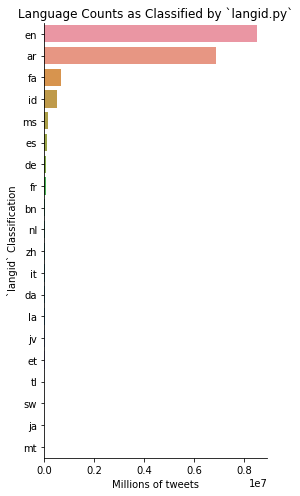

In [7]:
plot_value_counts(lang_cnts, 'value', 'langid',
                  'Language Counts as Classified by `langid.py`', 'Millions of tweets', '`langid` Classification')

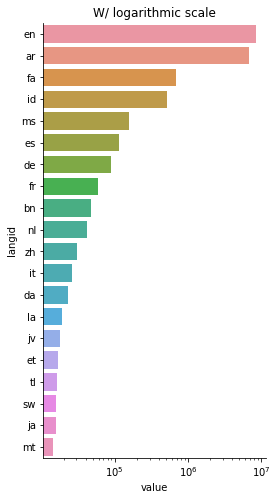

In [8]:
plot_value_counts(lang_cnts, 'value', 'langid', title='W/ logarithmic scale', scale='log')

What do the (<small>*langid-classified*</small>) non-english tweets look like? Is there an acceptable level of misclassified english tweets?

*Re-run 2nd cell for another random sampling*

In [9]:
lang_invalid = lang_df[lang_df.langid != 'en']

In [10]:
lang_invalid[['message', 'langid']].sample(25)

,message,langid
tweetID,,
828095156721221632,Jis Ne Kisi Khair-O-BhaLai K Kaam Ki Taraf Rah...,ms
816317003594080256,يا حي يا قيوم برحمتك أستغيث أصلح لي شأني كُله ♻️,ar
815870721545080832,أذكار الأذان:اللهم رب هذه الدعوة التامة والصلا...,ar
824349398188617728,اللهم صل وسلم على نبينا محمد ♻️,ar
827113074263982081,يا حي يا قيوم برحمتك أستغيث أصلح لي شأني كُله ♻️,ar
819845068601356288,اللهم لا سهل إلا ما جعلته سهلاً وأنت تجعل الحز...,ar
823708785986441216,سبحان الله وبحمده سبحان الله العظيم ♻️,ar
820265741891026945,أعوذ بكلمات الله التامات من شر ما خلق ♻️,ar
820204077250449408,أذكار الأذان:يدعو لنفسه بين الأذان والإقامة فإ...,ar


**Takeways?**

- Arabic was *very* popular, almost more popular than english. But Farsi and Indian were also popular.

---

### 3. [Space classification](#space) 🌎 🗺️ 


This is less comprehensive... Because it was extracted from the Postgres table `filter_tweets`, which had non-english tweets dropped from it. The data was created by joining the filtered tweets on the counties table with the following SQL query:

    SELECT 
        filter_tweets."tweetID",
        counties.geoid 
    FROM
        filter_tweets 
    LEFT OUTER JOIN
        counties 
    ON
        ST_Intersects(
            ST_SetSRID(
                ST_MakePoint(filter_tweets.longitude, filter_tweets.latitude), 
                4326),
            counties.geom
        );
        
Before we start, let's take a peek at the data so we know what to read in.

In [11]:
!head -n 2 ../data/interim/geoids.csv

,tweetID,geoid
0,826484798478770176,48453


In [12]:
# Read in the geography
geo_df = pd.read_csv(geoids_f, usecols=['tweetID', 'geoid'], index_col='tweetID',
                    dtype={'geoid': str})

# Gather counts
geo_tot = len(geo_df.index)
geo_located = len(geo_df[geo_df['geoid'].isnull() == False])
geo_n_located = len(geo_df[geo_df['geoid'].isnull()])

# Report out
print ('Tot: {}\nLocated: {}\nNot: {}\n\n'.format(geo_tot, geo_located, geo_n_located))

geo_df.head()

Tot: 8497484
Located: 2195819
Not: 6301665




,geoid
tweetID,
826484798478770176,48453
826484798583603201,01125
826484799263141888,08031
826484799342800896,06073
826484799527329792,NaN


What are the most active counties?

In [13]:
cnty_cnts = make_value_counts(geo_df, 'geoid')
cnty_cnt = len(cnty_cnts.index)

print ('{} counties matched\n\n'.format(cnty_cnt))
cnty_cnts.head()

430 counties matched




,geoid,value
0,NaN,6301665
1,36061,210637
2,06037,185091
3,11001,115623
4,17031,72996


In [14]:
#plot_value_counts(cnty_cnts, 'value', 'geoid',
#                  'County-Tweet Intersection Counts using EPSG:4326', 'cnt', 'County')

---

### 4. [Time Periods](#time) 📅 🕑

Note, in my original filter SQL query I used date instead of timestamp to select rows. I had not yet done the epoch calculations yet.

In [15]:
!head -n 3 ../data/interim/time-periods.csv

tweetID,date,period
826601467255595008,2017-01-31 19:22:01,1
826601469017194496,2017-01-31 19:22:02,1


In [16]:
date_df = pd.read_csv(periods_f, index_col='date', parse_dates=['date'], infer_datetime_format=True)

# Gather counts
date_tot = len(date_df.index)
date_valid = len(date_df[date_df['period'].isnull() == False])
date_n_valid = len(date_df[date_df['period'].isnull()])

# Report out
print ('Tot: {}\nValid: {}\nNot: {}\n\n'.format(date_tot, date_valid, date_n_valid))

date_df.head()

Tot: 8497484
Valid: 8481688
Not: 15796




,tweetID,period
date,,
2017-01-31 19:22:01,826601467255595008,1.0
2017-01-31 19:22:02,826601469017194496,1.0
2017-01-31 19:22:02,826601470044803073,1.0
2017-01-31 19:22:02,826601470321639425,1.0
2017-01-31 19:22:02,826601470531219456,1.0


What is the distribution of the time periods?

In [17]:
period_cnts = make_value_counts(date_df, 'period', drop=True)[:9]
period_cnts.sort_values('period', inplace=True)
period_cnts.iloc[:]

,period,value
7,-4,433931
6,-3,455914
5,-2,503966
4,-1,761360
8,0,256522
0,1,2720842
1,2,1345327
3,3,988961
2,4,1014865


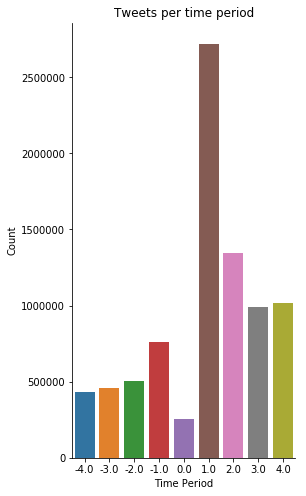

In [18]:
plot_value_counts(period_cnts, 'period', 'value',
                 'Tweets per time period', 'Time Period', 'Count')

How many were there by date?

In [19]:
# Add the date as a column
date_df.reset_index(inplace=True)

# Rename our erroneous date index to a more accurate 'timestamp'
date_df.rename(columns={'date': 'timestamp'}, inplace=True)

# Create a pure date column
date_df.loc[:, 'date'] = date_df.timestamp.apply(lambda x: str(x.date()))

In [20]:
date_df.head()

,timestamp,tweetID,period,date
0,2017-01-31 19:22:01,826601467255595008,1.0,2017-01-31
1,2017-01-31 19:22:02,826601469017194496,1.0,2017-01-31
2,2017-01-31 19:22:02,826601470044803073,1.0,2017-01-31
3,2017-01-31 19:22:02,826601470321639425,1.0,2017-01-31
4,2017-01-31 19:22:02,826601470531219456,1.0,2017-01-31


In [21]:
date_cnts = make_value_counts(date_df, 'date')
#date_cnts.loc[:, 'date'] = pd.to_datetime(date_cnts['date'], format='%Y-%m-%d')
#plot_value_counts(date_cnts, 'date', 'value')

In [22]:
#plt.figure(figsize=(12, 5))
date_cnts.dtypes

date     object
value    object
dtype: object

In [ ]:
#### STILL NEEDS VISUALIZATION

---

### Next Steps

1. Take a look at the languages as from `langid.py`
2. Reproject the counties to Albers Equal Area
3. Time periods is good ✅

**Merging into Canonical Dataset** Although we still have some reshaping to do for the canonical dataset, the merging process will be the same.

Grab only the valid rows from the calculated dataframes.

In [24]:
slim_lang_df = lang_df[lang_df.langid == 'en']
slim_geo_df = geo_df.dropna(subset=['geoid'])
slim_date_df = date_df[date_df.period.isnull() == False][['tweetID', 'period']].set_index('tweetID')

Merge the dataframes by joining them on their indices (`tweetID`).

In [25]:
space_and_time = pd.merge(slim_date_df, slim_geo_df, left_index=True, right_index=True)
print ('valid space and time tweets: {}\n'.format(len(space_and_time.index)))
space_and_time.head(1)

valid space and time tweets: 2195340



,period,geoid
tweetID,,
826601467255595008,1.0,51107


In [26]:
features_df = pd.merge(slim_lang_df, space_and_time, left_index=True, right_index=True)

print ('All valid tweets: {}\n'.format(len(features_df.index)))

All valid tweets: 2195340



,message,langid,period,geoid
tweetID,,,,
826284337259827206,It's not going to be easy being a Muslim in Am...,en,1.0,11001
826284337343639553,WTF is going on? Trump is completely out of co...,en,1.0,06075
826284337838510080,Acting US Attorney General Sally Yates has bee...,en,1.0,51059
826284338035691521,Obama's administration made the 'Muslim ban' p...,en,1.0,06037
826284338920751104,...we are weaker when divided..its time 4 a Mu...,en,1.0,36061


In [27]:
features_df = features_df[['message', 'period', 'geoid']].reset_index()
features_df.head()

,tweetID,message,period,geoid
0,826284337259827206,It's not going to be easy being a Muslim in Am...,1.0,11001
1,826284337343639553,WTF is going on? Trump is completely out of co...,1.0,06075
2,826284337838510080,Acting US Attorney General Sally Yates has bee...,1.0,51059
3,826284338035691521,Obama's administration made the 'Muslim ban' p...,1.0,06037
4,826284338920751104,...we are weaker when divided..its time 4 a Mu...,1.0,36061


In [28]:
# write it out
features_df.to_csv('../tweet-features.csv', index=False)